In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from utils import calc_embeddings, plot_embeddings
from utils import TripletMNIST, TripletLoss

### Architecture

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
    
    def embed(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x
    
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4, 256),
                                nn.PReLU(),
                                nn.Linear(256, 256),
                                nn.PReLU(),
                                nn.Linear(256, 2)
                                )

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output
    
    def embed(self, x):
        return self.forward(x)
    
class ClassificationNet(nn.Module):
    def __init__(self, embedding_net, n_classes):
        super(ClassificationNet, self).__init__()
        self.embedding_net = embedding_net
        self.n_classes = n_classes
        self.nonlinear = nn.PReLU()
        self.fc1 = nn.Linear(2, n_classes)

    def forward(self, x):
        output = self.embedding_net(x)
        output = self.nonlinear(output)
        scores = F.log_softmax(self.fc1(output), dim=-1)
        return scores
    
    def embed(self,x):
        return self.embedding_net(x)
    
class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2, x3):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        output3 = self.embedding_net(x3)
        return output1, output2, output3
    
    def embed(self, x):
        return self.embedding_net(x)

In [3]:
def train(model, device, train_loader, optimizer, epoch, log_interval = 10, dry_run=False):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [4]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Model training & testing

In [62]:
seed = 7
batch_size = 64
test_batch_size = 64
use_cuda = True
lr = 1e-4
gamma = 0.9
epochs = 20
save_model = True
log_interval = 100

torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('mnist/', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('mnist/', train=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

# model = Net().to(device)
# model = ClassifyNet(EmbedNet().to(device)).to(device)
embedding_net = EmbeddingNet()
model = ClassificationNet(embedding_net, 10).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    test(model, device, test_loader)
    scheduler.step()

if save_model:
    torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.459039
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.902423
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.858556
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.605989
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.610815
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.765878
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.355652
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.243432
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.330807
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.211268

Test set: Average loss: 1.2080, Accuracy: 4361/10000 (44%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.429173
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.052402
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.049907
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.165383
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.134897
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.236386
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.816909
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.761395
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.707539
T

Train Epoch: 15 [51200/60000 (85%)]	Loss: 0.106546
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.150883

Test set: Average loss: 0.1519, Accuracy: 9682/10000 (97%)

Train Epoch: 16 [0/60000 (0%)]	Loss: 0.098951
Train Epoch: 16 [6400/60000 (11%)]	Loss: 0.067596
Train Epoch: 16 [12800/60000 (21%)]	Loss: 0.091834
Train Epoch: 16 [19200/60000 (32%)]	Loss: 0.147618
Train Epoch: 16 [25600/60000 (43%)]	Loss: 0.079263
Train Epoch: 16 [32000/60000 (53%)]	Loss: 0.041711
Train Epoch: 16 [38400/60000 (64%)]	Loss: 0.087941
Train Epoch: 16 [44800/60000 (75%)]	Loss: 0.093486
Train Epoch: 16 [51200/60000 (85%)]	Loss: 0.067019
Train Epoch: 16 [57600/60000 (96%)]	Loss: 0.051161

Test set: Average loss: 0.1427, Accuracy: 9722/10000 (97%)

Train Epoch: 17 [0/60000 (0%)]	Loss: 0.071938
Train Epoch: 17 [6400/60000 (11%)]	Loss: 0.095294
Train Epoch: 17 [12800/60000 (21%)]	Loss: 0.077742
Train Epoch: 17 [19200/60000 (32%)]	Loss: 0.117458
Train Epoch: 17 [25600/60000 (43%)]	Loss: 0.086732
Train Epoch: 17 [32000/

### Embeddings calculation

In [63]:
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1)

In [100]:
embeddings, labels = calc_embeddings(model, device, test_loader)

100%|██████████| 10000/10000 [00:07<00:00, 1414.06it/s]


### TSNE visualization

In [101]:
# X_embedded = TSNE(n_components=2).fit_transform(embeddings)
# plot_embeddings(X_embedded, labels)

### PCA visualization

In [102]:
# X_embedded = PCA(n_components=2).fit_transform(embeddings)
# plot_embeddings(X_embedded, labels)

### Normal visualization of 2-D embeddings

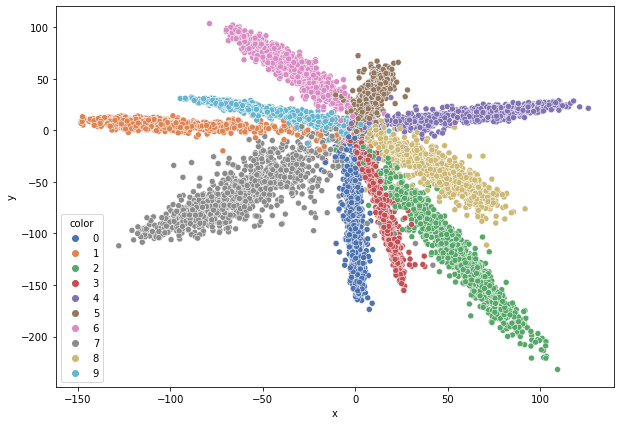

In [103]:
plot_embeddings(embeddings, labels)

### Saliency maps

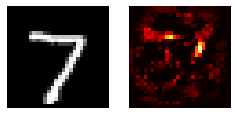

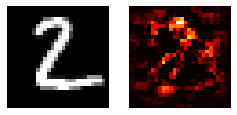

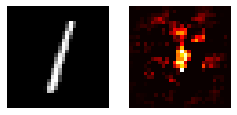

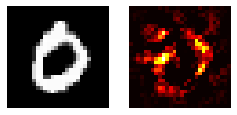

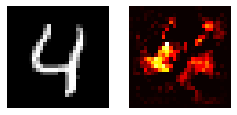

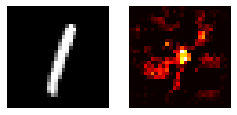

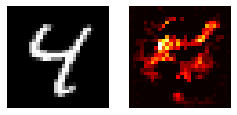

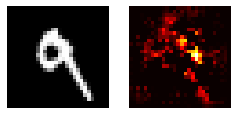

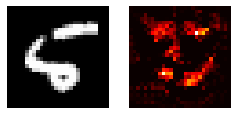

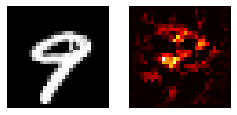

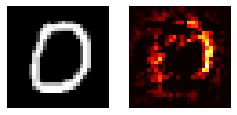

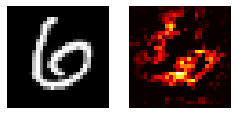

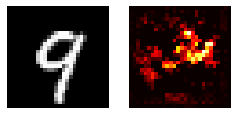

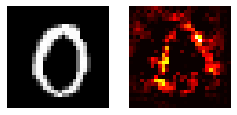

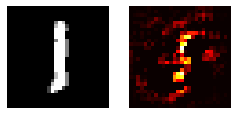

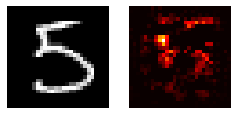

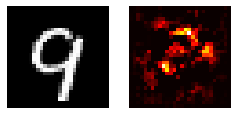

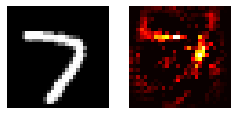

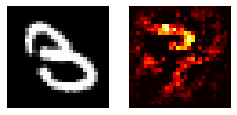

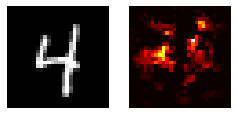

In [109]:
def saliency_map(data, model):
    # https://arxiv.org/pdf/1312.6034.pdf
    
    # run the model in eval mode
    model.eval()
    
    # calculate gradient with respect to the input image
    data.requires_grad_()
    
    # forward pass
    output = model(data)
    
    # max score (predicted class)
    score_max_index = output.argmax()
    score_max = output[0,score_max_index]
    
    # backward pass to get gradients of score predicted class w.r.t. input image
    score_max.backward()
#     saliency, _ = torch.max(data.grad.data.abs(), dim=0)

    # slight modification: only positive gradients
    saliency, _ = torch.max(data.grad.data, dim=0)
    saliency *= saliency > 0 # useful to get rid of negative gradients
    
    # normalize saliency map
    saliency = (saliency - saliency.min())/(saliency.max()-saliency.min())

    # code to plot the saliency map as a heatmap
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(4, 3)
#     plt.suptitle(score_max_index.item())
    ax1.imshow(data.detach().cpu().numpy().reshape(28,28), cmap='gray')
    ax2.imshow(saliency.cpu().numpy().reshape(-1,28), cmap='hot')
    ax1.axis('off')
    ax2.axis('off')
    

i = 20
for data, target in test_loader:
    i-=1
    data, target = data.to(device), target.to(device)
    
    saliency_map(data, model)
    if i == 0:
        break

_______________

# Triplets

In [112]:
def train_tripletnet(model, device, train_loader, optimizer, epoch, log_interval = 10, dry_run=False):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = tuple(d.cuda() for d in data)
        
        optimizer.zero_grad()        
        outputs = model(*data)
        loss_inputs = outputs
        loss_fn = TripletLoss(1.0)
        
        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test_tripletnet(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = tuple(d.cuda() for d in data)
            
            outputs = model(*data)

            loss_inputs = outputs
            loss_fn = TripletLoss(1.0)

            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            test_loss += loss.item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))

In [113]:
seed = 7
batch_size = 64
test_batch_size = 64
use_cuda = True
lr = 1e-4
gamma = 0.9
epochs = 20
save_model = True
log_interval = 100

torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if use_cuda: 
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

dataset1 = datasets.MNIST('mnist/', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('mnist/', train=False,
                   transform=transform)
triplet_train_dataset = TripletMNIST(dataset1)
triplet_test_dataset = TripletMNIST(dataset2)
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, **train_kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, **test_kwargs)

embedding_net = EmbeddingNet()
model = TripletNet(embedding_net).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
for epoch in range(1, epochs + 1):
    train_tripletnet(model, device, triplet_train_loader, optimizer, epoch, log_interval)
    test_tripletnet(model, device, triplet_test_loader)
    scheduler.step()

if save_model:
    torch.save(model.state_dict(), "mnist_cnn_triplet.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.999611
Train Epoch: 1 [300/60000 (11%)]	Loss: 0.380108
Train Epoch: 1 [600/60000 (21%)]	Loss: 0.220213
Train Epoch: 1 [900/60000 (32%)]	Loss: 0.253416
Train Epoch: 1 [1200/60000 (43%)]	Loss: 0.068100
Train Epoch: 1 [1500/60000 (53%)]	Loss: 0.109638
Train Epoch: 1 [1800/60000 (64%)]	Loss: 0.155492
Train Epoch: 1 [2100/60000 (75%)]	Loss: 0.199299
Train Epoch: 1 [2400/60000 (85%)]	Loss: 0.123426
Train Epoch: 1 [2700/60000 (96%)]	Loss: 0.213525

Test set: Average loss: 0.0020

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.092617
Train Epoch: 2 [300/60000 (11%)]	Loss: 0.246757
Train Epoch: 2 [600/60000 (21%)]	Loss: 0.140898
Train Epoch: 2 [900/60000 (32%)]	Loss: 0.114016
Train Epoch: 2 [1200/60000 (43%)]	Loss: 0.086292
Train Epoch: 2 [1500/60000 (53%)]	Loss: 0.145070
Train Epoch: 2 [1800/60000 (64%)]	Loss: 0.069844
Train Epoch: 2 [2100/60000 (75%)]	Loss: 0.053731
Train Epoch: 2 [2400/60000 (85%)]	Loss: 0.086499
Train Epoch: 2 [2700/60000 (96%)]	Loss: 0.016459



Train Epoch: 16 [2400/60000 (85%)]	Loss: 0.000000
Train Epoch: 16 [2700/60000 (96%)]	Loss: 0.004147

Test set: Average loss: 0.0004

Train Epoch: 17 [0/60000 (0%)]	Loss: 0.000000
Train Epoch: 17 [300/60000 (11%)]	Loss: 0.012593
Train Epoch: 17 [600/60000 (21%)]	Loss: 0.000000
Train Epoch: 17 [900/60000 (32%)]	Loss: 0.000000
Train Epoch: 17 [1200/60000 (43%)]	Loss: 0.000000
Train Epoch: 17 [1500/60000 (53%)]	Loss: 0.041280
Train Epoch: 17 [1800/60000 (64%)]	Loss: 0.016868
Train Epoch: 17 [2100/60000 (75%)]	Loss: 0.000000
Train Epoch: 17 [2400/60000 (85%)]	Loss: 0.042024
Train Epoch: 17 [2700/60000 (96%)]	Loss: 0.008995

Test set: Average loss: 0.0004

Train Epoch: 18 [0/60000 (0%)]	Loss: 0.000000
Train Epoch: 18 [300/60000 (11%)]	Loss: 0.058104
Train Epoch: 18 [600/60000 (21%)]	Loss: 0.011095
Train Epoch: 18 [900/60000 (32%)]	Loss: 0.006941
Train Epoch: 18 [1200/60000 (43%)]	Loss: 0.000000
Train Epoch: 18 [1500/60000 (53%)]	Loss: 0.047060
Train Epoch: 18 [1800/60000 (64%)]	Loss: 0.00000

In [114]:
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1)
embeddings, labels = calc_embeddings(model, device, test_loader)

100%|██████████| 10000/10000 [00:07<00:00, 1360.73it/s]


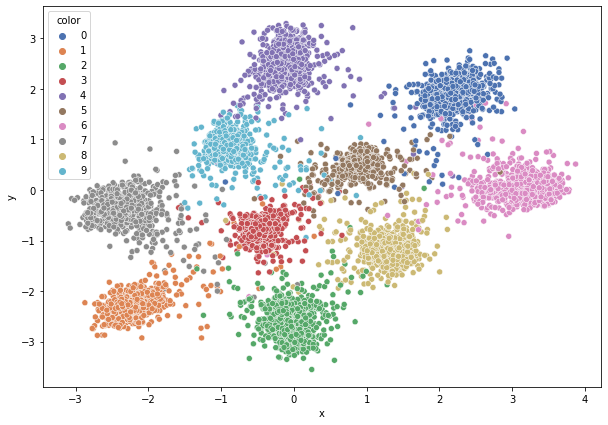

In [115]:
plot_embeddings(embeddings, labels)

### Test it on pre-trained embedding net

In [116]:
seed = 7
batch_size = 64
test_batch_size = 64
use_cuda = True
lr = 1e-4
gamma = 0.9
epochs = 20
save_model = True
log_interval = 100

torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('mnist/', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('mnist/', train=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

# model = Net().to(device)
# model = ClassifyNet(EmbedNet().to(device)).to(device)
embedding_net = EmbeddingNet()
model = ClassificationNet(embedding_net, 10).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    test(model, device, test_loader)
    scheduler.step()

if save_model:
    torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.459039
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.902423
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.858387
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.607835
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.617370
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.767951
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.355757
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.242854
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.329614
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.216402

Test set: Average loss: 1.2097, Accuracy: 4343/10000 (43%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.434508
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.049720
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.058506
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.165708
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.116395
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.263959
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.812703
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.763645
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.706631
T

Train Epoch: 15 [51200/60000 (85%)]	Loss: 0.104702
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.127204

Test set: Average loss: 0.1473, Accuracy: 9680/10000 (97%)

Train Epoch: 16 [0/60000 (0%)]	Loss: 0.108560
Train Epoch: 16 [6400/60000 (11%)]	Loss: 0.069129
Train Epoch: 16 [12800/60000 (21%)]	Loss: 0.098651
Train Epoch: 16 [19200/60000 (32%)]	Loss: 0.117214
Train Epoch: 16 [25600/60000 (43%)]	Loss: 0.049370
Train Epoch: 16 [32000/60000 (53%)]	Loss: 0.044436
Train Epoch: 16 [38400/60000 (64%)]	Loss: 0.079188
Train Epoch: 16 [44800/60000 (75%)]	Loss: 0.105791
Train Epoch: 16 [51200/60000 (85%)]	Loss: 0.058880
Train Epoch: 16 [57600/60000 (96%)]	Loss: 0.058698

Test set: Average loss: 0.1401, Accuracy: 9722/10000 (97%)

Train Epoch: 17 [0/60000 (0%)]	Loss: 0.082684
Train Epoch: 17 [6400/60000 (11%)]	Loss: 0.094869
Train Epoch: 17 [12800/60000 (21%)]	Loss: 0.063297
Train Epoch: 17 [19200/60000 (32%)]	Loss: 0.130480
Train Epoch: 17 [25600/60000 (43%)]	Loss: 0.069034
Train Epoch: 17 [32000/

In [123]:
seed = 7
batch_size = 64
test_batch_size = 64
use_cuda = True
lr = 1e-4
gamma = 0.9
epochs = 20
save_model = True
log_interval = 100

torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if use_cuda: 
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

dataset1 = datasets.MNIST('mnist/', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('mnist/', train=False,
                   transform=transform)
triplet_train_dataset = TripletMNIST(dataset1)
triplet_test_dataset = TripletMNIST(dataset2)
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, **train_kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, **test_kwargs)

# load pretrained embedding model
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
for epoch in range(1, epochs + 1):
    train_tripletnet(model, device, triplet_train_loader, optimizer, epoch, log_interval)
    test_tripletnet(model, device, triplet_test_loader)
    scheduler.step()

if save_model:
    torch.save(model.state_dict(), "mnist_cnn_triplet.pt")

/home/dhorna/anaconda3/envs/mgr/lib/python3.7/site-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/dhorna/anaconda3/envs/mgr/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/dhorna/anaconda3/envs/mgr/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/home/dhorna/anaconda3/envs/mgr/lib/python3.7/site-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


Train Epoch: 1 [0/60000 (0%)]	Loss: 747.495544
Train Epoch: 1 [300/60000 (11%)]	Loss: 561.834167
Train Epoch: 1 [600/60000 (21%)]	Loss: 142.408112
Train Epoch: 1 [900/60000 (32%)]	Loss: 22.239292
Train Epoch: 1 [1200/60000 (43%)]	Loss: 270.735840
Train Epoch: 1 [1500/60000 (53%)]	Loss: 8.782886
Train Epoch: 1 [1800/60000 (64%)]	Loss: 11.516394
Train Epoch: 1 [2100/60000 (75%)]	Loss: 0.000000
Train Epoch: 1 [2400/60000 (85%)]	Loss: 25.993572
Train Epoch: 1 [2700/60000 (96%)]	Loss: 0.231803

Test set: Average loss: 0.1815

Train Epoch: 2 [0/60000 (0%)]	Loss: 15.056595
Train Epoch: 2 [300/60000 (11%)]	Loss: 1.413872
Train Epoch: 2 [600/60000 (21%)]	Loss: 1.928533
Train Epoch: 2 [900/60000 (32%)]	Loss: 7.532179
Train Epoch: 2 [1200/60000 (43%)]	Loss: 3.852262
Train Epoch: 2 [1500/60000 (53%)]	Loss: 7.622608
Train Epoch: 2 [1800/60000 (64%)]	Loss: 3.220363
Train Epoch: 2 [2100/60000 (75%)]	Loss: 0.167845
Train Epoch: 2 [2400/60000 (85%)]	Loss: 6.359123
Train Epoch: 2 [2700/60000 (96%)]	Loss

Train Epoch: 16 [2400/60000 (85%)]	Loss: 0.071930
Train Epoch: 16 [2700/60000 (96%)]	Loss: 0.006644

Test set: Average loss: 0.0006

Train Epoch: 17 [0/60000 (0%)]	Loss: 0.010509
Train Epoch: 17 [300/60000 (11%)]	Loss: 0.000000
Train Epoch: 17 [600/60000 (21%)]	Loss: 0.010393
Train Epoch: 17 [900/60000 (32%)]	Loss: 0.014054
Train Epoch: 17 [1200/60000 (43%)]	Loss: 0.031946
Train Epoch: 17 [1500/60000 (53%)]	Loss: 0.000494
Train Epoch: 17 [1800/60000 (64%)]	Loss: 0.014971
Train Epoch: 17 [2100/60000 (75%)]	Loss: 0.007809
Train Epoch: 17 [2400/60000 (85%)]	Loss: 0.130758
Train Epoch: 17 [2700/60000 (96%)]	Loss: 0.000000

Test set: Average loss: 0.0006

Train Epoch: 18 [0/60000 (0%)]	Loss: 0.019733
Train Epoch: 18 [300/60000 (11%)]	Loss: 0.006145
Train Epoch: 18 [600/60000 (21%)]	Loss: 0.001215
Train Epoch: 18 [900/60000 (32%)]	Loss: 0.000000
Train Epoch: 18 [1200/60000 (43%)]	Loss: 0.002208
Train Epoch: 18 [1500/60000 (53%)]	Loss: 0.000524
Train Epoch: 18 [1800/60000 (64%)]	Loss: 0.10376

In [124]:
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1)
embeddings, labels = calc_embeddings(model, device, test_loader)

100%|██████████| 10000/10000 [00:07<00:00, 1421.44it/s]


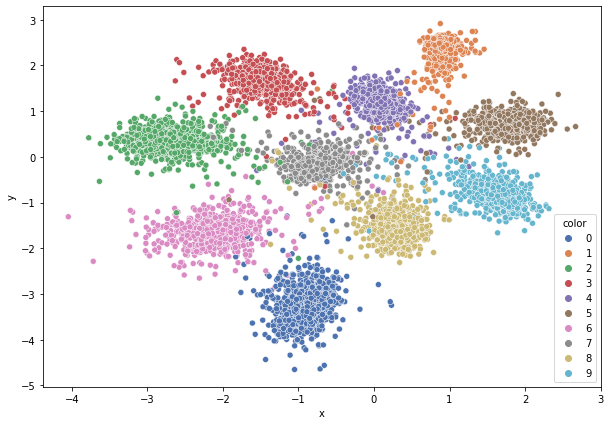

In [125]:
plot_embeddings(embeddings, labels)

In [133]:
embeddings.shape

(10000, 2)

In [134]:
loader_labels = []

i = 1
for data, target in test_loader:
    loader_labels.append(target.item())

In [142]:
cluster_means = {}

for i in range(10):
    cluster_means[i] = np.mean(embeddings[np.array(loader_labels) == i, :], axis=0)

In [143]:
cluster_means

{0: array([-0.91653526, -3.2394059 ], dtype=float32),
 1: array([0.8963293, 2.300509 ], dtype=float32),
 2: array([-2.6597364,  0.3465488], dtype=float32),
 3: array([-1.4724672,  1.6359487], dtype=float32),
 4: array([0.0948402, 1.1442225], dtype=float32),
 5: array([1.7636243, 0.7123662], dtype=float32),
 6: array([-2.0816312, -1.634363 ], dtype=float32),
 7: array([-0.7485262 , -0.17847686], dtype=float32),
 8: array([ 0.248511 , -1.5215521], dtype=float32),
 9: array([ 1.6362247, -0.8463339], dtype=float32)}

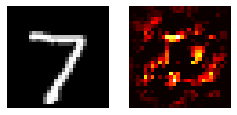

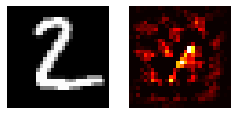

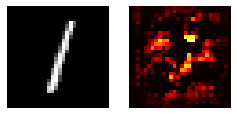

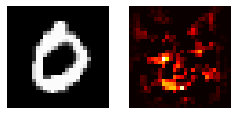

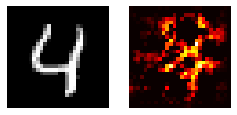

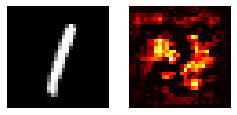

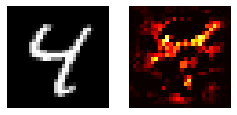

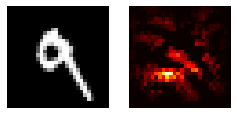

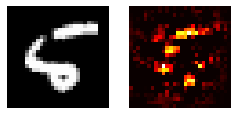

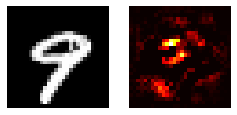

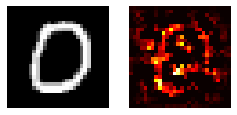

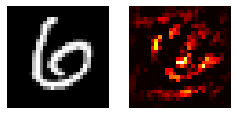

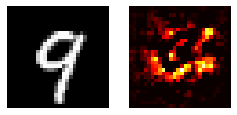

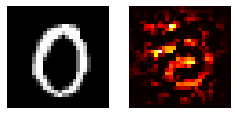

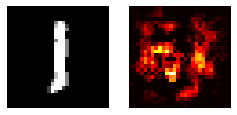

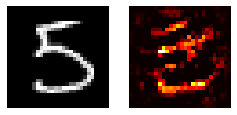

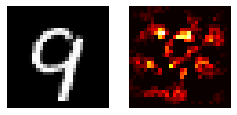

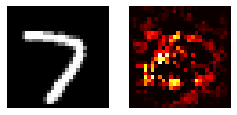

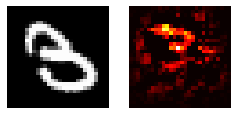

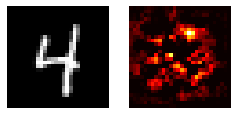

In [166]:
def saliency_map_triplet(data, target, model):
    # https://arxiv.org/pdf/1312.6034.pdf
    
    # run the model in eval mode
    model.eval()
    
    # calculate gradient with respect to the input image
    data.requires_grad_()
    
    # forward pass
    embedding = model.embed(data)
    
    # max score (predicted class)
#     score_max_index = output.argmax()
#     score_max = output[0,score_max_index]
    
    # backward pass to get gradients of score predicted class w.r.t. input image
#     score_max.backward()
#     saliency, _ = torch.max(data.grad.data.abs(), dim=0)

    # backward pass to get gradients of distance to predicted class wrt input image
    
#     print(embedding)
#     print(target)
#     print(cluster_means[target.item()])
#     print(torch.tensor(cluster_means[target.item()]).to(device))
    target_cluster_mean = torch.tensor(cluster_means[target.item()]).to(device)
    distance_to_cluster_mean = torch.norm(embedding-target_cluster_mean)
    distance_to_cluster_mean.backward()

    # slight modification: only positive gradients
#     saliency, _ = torch.max(data.grad.data.abs(), dim=0)

    saliency, _ = torch.max(data.grad.data, dim=0)
#     saliency *= saliency > 0
    saliency *= saliency < 0 # useful to get rid of negative gradients
    saliency *= -1
    
    # normalize saliency map
    saliency = (saliency - saliency.min())/(saliency.max()-saliency.min())

    # code to plot the saliency map as a heatmap
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(4, 3)
#     plt.suptitle(score_max_index.item())
    ax1.imshow(data.detach().cpu().numpy().reshape(28,28), cmap='gray')
    ax2.imshow(saliency.cpu().numpy().reshape(-1,28), cmap='hot')
    ax1.axis('off')
    ax2.axis('off')
    

i = 20
for data, target in test_loader:
    i-=1
    data, target = data.to(device), target.to(device)
    
    saliency_map_triplet(data, target, model)
    if i == 0:
        break